## Data analysis of Flappy bird

The goal of this project is to create a DQN (deep Q-learning Network) to find optimal policy set to get a high score on the game flappybird.  How the game works is as follows: <br>

1. The user controls a bird in the middle of a side-scrolling screen.<br>
2. The bird has two possible actions. It either falls (which is the default action) or it rises (when the user taps the screen, or in the case of PLE, when the user hits the 'w' key.)<br>
3. The environment is set up with randomly sized and positioned pipes, which the user must maneuver the bird over, under, or between.<br>
4. The score for the trial is based on how many pipes the user is able to navitage through.  The game reaches a terminal state when the bird crashes into the pipe, or hits the ceiling or bottom of the game screen.<br>


This notebook will focus on analyzing the data behind flappy birds. Some of the questions to be answered are below:

1. How is the game state represented? <br>
2. What are the possible actions? How are they encoded?


In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE

import skimage

from skimage import data, io
from skimage.transform import rotate
from skimage.color import rgb2gray, rgb2grey

#image editing
from skimage import feature, filters
#from skimage import *
import cPickle as pickle

import matplotlib.pyplot as plt

##data file location
data_output = '/users/momori/data/stacked_images.pkl'

from classes import *

couldn't import doomish
Couldn't import doom


In [69]:
#init the game flappybird
game = FlappyBird()

#set up the screen
p = PLE(game, fps=30, display_screen=True)

p.init()

print 'possible actions are:', p.getActionSet()

num_frames = 401 ##first frame is null
observations = []
game_over = False
for i in range(num_frames):
    if p.game_over():
        p.reset_game()

    observation = p.getScreenRGB()
    observations.append(observation)
    reward = p.act(None)
    if reward != 0 and not game_over:
        print reward
        game_over = True

    

possible actions are: [119, None]
-5.0


From the above output, we can see that there are two actions. The value 119 will que the bird to flap upwards, where as doing nothing will lower the altitude.  Once the termination requirements are set, in which case p.game_over() will return True, the trial is done and given a score of -5.0.  Then the game is reset.  

The observations list contains representation of some of the states of the game.  Below we will analyze them.

## State Representation

We notice below that each state is represented as an ndarray, with dimensions of (288, 512, 3).  The 3 is for the RGB values, and the actual window size is set up to be 288 high and 512 pixels wide.  According to this article, https://yanpanlau.github.io/2016/07/10/FlappyBird-Keras.html, it is recommended that we do some image reconstruction on these state representations.  By converting the image into grayscale, we can reduce the dimensionality of the image, hence improving the speed for the neural network to train on.  Also, feeding in one frame at a time to the network will not depict whether the bird is going up or down.  Therfore, the recommendation is to stack 4 frames together and put it as one sample point.  We will utilize the skimage library to change the representations.

In [3]:
print type(observations[1]), observations[1].shape

<type 'numpy.ndarray'> (288, 512, 3)


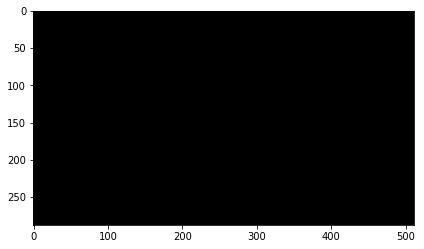

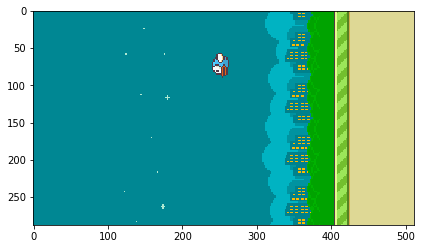

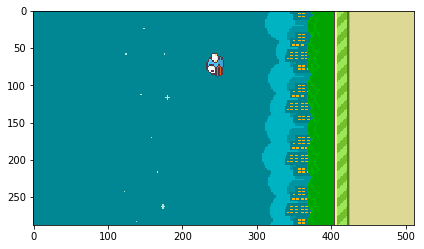

In [6]:
io.imshow(observations[0])
plt.show()
io.imshow(observations[2])
plt.show()
io.imshow(observations[3])
plt.show()

In [82]:
class ImageProcessor():
    '''Class used to stack and convert images into grayscale
    args: 
        image: ndarray image of the flappybird state representation
    '''
    def __init__(self, orig_image):
        self._orig_image = orig_image
        
        #convert into grayscale, crop out the bottom and downsample
        self._gray_image = skimage.color.rgb2gray(
            orig_image[:,:340][::3,::3])
        
    @property
    def gray_image(self):
        return self._gray_image
    
    @gray_image.setter
    def gray_image(self, image):
        self._orig_image = image
        self._gray_image = skimage.color.rgb2gray(image)
        
    @property 
    def orig_image(self):
        return self._orig_image
    
    @orig_image.setter
    def orig_image(self, image):
        self._orig_image = image
        self._gray_image = skimage.color.rgb2gray(image)
        
    def show_image(self, gray=True):
        if gray:
            io.imshow(self._gray_image)
        else:
            io.imshow(self._orig_image)
        plt.show()
        
    def shape(self):
        print 'original image shape:', self._orig_image.shape
        print 'gray image eshape:', self._gray_image.shape
        
    def matrix(self, gray=True):
        return self._gray_image
    
    def is_first_frame(self):
        '''seems first frame is always dark. Used to detect
        if the state value is all 0 or not'''
        return np.max(self._gray_image) == 0

In [83]:
class StackedImages():
    '''object to keep the stacked frames together for organization.
    organized as a list of stacked ndarrays'''
    def __init__(self, image_processors = None, num_per_stack = None):
        if type(image_processors) is not list:
            print 'images need to be a list'
        else:
            self._stacked_images = []
            for i in range(0, len(image_processors), num_per_stack):
                list_images = [image_processors[i].gray_image for i in 
                              range(i, i+num_per_stack)]
                stacked = np.stack(list_images, axis=0)
                self._stacked_images.append(stacked)
#             self._images = [i.gray_image for i in images]
#             self._stacked_images = np.stack(self._images, axis=0)
    
    def plot(self):
        for image in self._images:
            io.imshow(image)
            plt.show()
        
    def get_stacked_images(self):
        return self._stacked_images
    
    
    def get_shape(self):
        return self._stacked_images[0].shape
    
    def save(self, file_name):
        handle = open(file_name, 'w')
        pickle.dump(self.__dict__, handle, 2)
        handle.close()
        
    def load(self, file_name):
        handle = open(file_name, 'r')
        tmp_dict = pickle.load(handle)
        self.__dict__.clear()
        self.__dict__.update(tmp_dict)
        handle.close()
        
        

## Feature Reduction

To get DQN to learn faster and have more stability, we'd like to reduce the amount of unnecessary information in the state representation.  This includes the background, different shades of colors, etc. The article above suggests that we turn each frame into a gray scale image and reduce the dimensions.

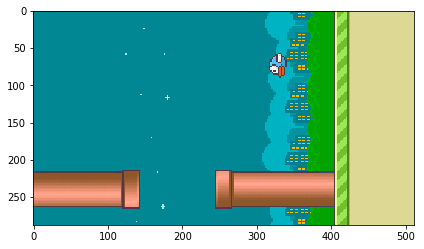

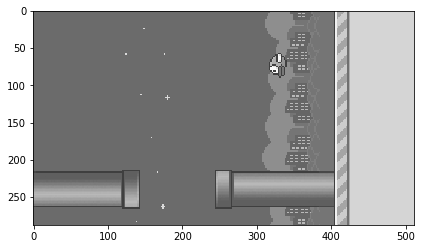

In [29]:
io.imshow(observations[25])
plt.show()
io.imshow(rgb2gray(observations[25]))
plt.show()

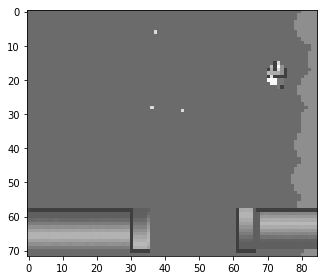

In [70]:
##(512, 288) -> down sample to (405, 288) to remove the ground.
io.imshow(rgb2gray(observations[21])[:,:340][::4, ::4])
plt.show()